In [4]:
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

import requests #for http requests
import bs4 #called `beautifulsoup4`, an html parser
import pandas #gives us DataFrames
import docx #reading MS doc files, install as `python-docx`

#Stuff for pdfs
#Install as `pdfminer2`
import pdfminer.pdfinterp
import pdfminer.converter
import pdfminer.layout
import pdfminer.pdfpage

#These come with Python
import re #for regexs
import urllib.parse #For joining urls
import io #for making http requests look like files
import json #For Tumblr API responses
import os.path #For checking if files exist
import os #For making directories

In [5]:
##Scraping for data
wikipedia_pedagogy = 'https://en.wikipedia.org/wiki/Pedagogy'
requests.get(wikipedia_pedagogy)
wikiContentRequest = requests.get(wikipedia_pedagogy)
wikiContentSoup = bs4.BeautifulSoup(wikiContentRequest.text, 'html.parser')

#Tag by paragraph because I want to compare between content from different wiki websites
contentPTags = wikiContentSoup.body.findAll('p')
contentParagraphs = []
for pTag in contentPTags:
    contentParagraphs.append(re.sub(r'\[\d+\]', '', pTag.text))
pdgDF = pandas.DataFrame({'paragraph-text' : contentParagraphs})

wikipedia_base_url = 'https://en.wikipedia.org'
otherPAgeURLS = []
for paragraphNum, pTag in enumerate(contentPTags):
    tagLinks = pTag.findAll('a', href=re.compile('/wiki/'), class_=False)
    for aTag in tagLinks:
        relurl = aTag.get('href')
        linkText = aTag.text
        otherPAgeURLS.append((
            urllib.parse.urljoin(wikipedia_base_url, relurl),
            paragraphNum,
            linkText,
        ))
        
pdgDF['source'] = [wikipedia_pedagogy] * len(pdgDF['paragraph-text']) #contentParagraphs=pdg
pdgDF['paragraph-number'] = range(len(pdgDF['paragraph-text']))

pdgDF

pdgDF['source-paragraph-number'] = [None] * len(pdgDF['paragraph-text'])
pdgDF['source-paragraph-text'] = [None] * len(pdgDF['paragraph-text'])

def getTextFromWikiPage(targetURL, sourceParNum, sourceText):
    #Make a dict to store data before adding it to the DataFrame
    parsDict = {'source' : [], 'paragraph-number' : [], 'paragraph-text' : [], 'source-paragraph-number' : [],  'source-paragraph-text' : []}
    #page
    r = requests.get(targetURL)
    soup = bs4.BeautifulSoup(r.text, 'html.parser')
    #enumerating 
    for parNum, pTag in enumerate(soup.body.findAll('p')):
        parsDict['paragraph-text'].append(re.sub(r'\[\d+\]', '', pTag.text))
        parsDict['paragraph-number'].append(parNum)
        parsDict['source'].append(targetURL)
        parsDict['source-paragraph-number'].append(sourceParNum)
        parsDict['source-paragraph-text'].append(sourceText)
    return pandas.DataFrame(parsDict)

for urlTuple in otherPAgeURLS[:3]:
    pdgDF = pdgDF.append(getTextFromWikiPage(*urlTuple),ignore_index=True)

In [6]:
#tokenize and normalized
pdgDF['tokenized_text'] = pdgDF['paragraph-text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
pdgDF['normalized_tokens'] = pdgDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [66]:
pdgDF[:5]

,paragraph-number,paragraph-text,source,source-paragraph-number,source-paragraph-text,tokenized_text,normalized_tokens
0,0,\n,https://en.wikipedia.org/wiki/Pedagogy,None,None,[],[]
1,1,"Pedagogy (/ˈpɛdəɡɒdʒi, -ɡoʊdʒi, -ɡɒɡi/), most ...",https://en.wikipedia.org/wiki/Pedagogy,None,None,"[Pedagogy, /ˈpɛdəɡɒdʒi, -ɡoʊdʒi, -ɡɒɡi/, most,...","[pedagogy, /ˈpɛdəɡɒdʒi, -ɡoʊdʒi, -ɡɒɡi/, commo..."
2,2,Pedagogy is often described as the act of teac...,https://en.wikipedia.org/wiki/Pedagogy,None,None,"[Pedagogy, is, often, described, as, the, act,...","[pedagogy, describe, act, teach, pedagogy, ado..."
3,3,Instructive strategies are governed by the pup...,https://en.wikipedia.org/wiki/Pedagogy,None,None,"[Instructive, strategies, are, governed, by, t...","[instructive, strategy, govern, pupil, backgro..."
4,4,"The teaching of adults, as a specific group, i...",https://en.wikipedia.org/wiki/Pedagogy,None,None,"[The, teaching, of, adults, as, a, specific, g...","[teach, adult, specific, group, refer, andragogy]"


In [67]:
#initialize
pdgTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
pdgTFVects = pdgTFVectorizer.fit_transform(pdgDF['paragraph-text'])

try:
    print(pdgTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('The available words are: {} ...'.format(list(pdgTFVectorizer.vocabulary_.keys())[:10]))

The available words are: ['pedagogy', 'commonly', 'approach', 'teaching', 'refers', 'theory', 'practice', 'process', 'influences', 'influenced'] ...


In [68]:
numClusters = len(set(pdgDF['source']))
numClusters
#Four clusters

4

In [69]:
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(pdgTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [70]:
#Top terms from each cluster
terms = pdgTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')
    
#four clusters with different features.
#Notably, cluster 3 consists of dense elements that are highly relevant to schooling and teaching
#Cluster 0 is also interesting that it is a cluster of crucial elements in learning and teaching

Top terms per cluster:
Cluster 0:
 play
 pronunciation
 ipa
 words
 symbols
 english
 different
 local
 stimulus
 dialogue


Cluster 1:
 education
 pedagogy
 pedagogues
 ce
 social
 used
 educational
 teaching
 academic
 online


Cluster 2:
 students
 student
 knowledge
 transfer
 teacher
 problem
 child
 use
 teaching
 instruction


Cluster 3:
 theory
 behavior
 information
 knowledge
 conditioning
 memory
 learn
 learner
 cognitive
 process




In [71]:
#PCA
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(pdgTFVects.toarray())
reduced_data = pca.transform(pdgTFVects.toarray())

In [72]:
colordict = {
'https://en.wikipedia.org/wiki/Pedagogy': 'red',
'https://en.wikipedia.org/wiki/Learning': 'blue',
'https://en.wikipedia.org/wiki/Learning_theory_(education)': 'black',
'https://en.wikipedia.org/wiki/Learning_theory_...': 'blue',
'https://en.wikipedia.org/wiki/Help:IPA/English': 'yellow',
    }
colors = [colordict[c] for c in pdgDF['source']]

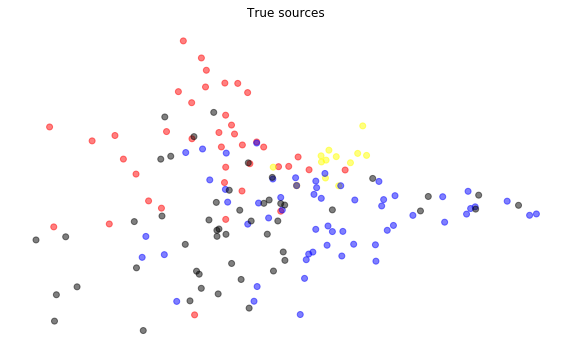

In [73]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True sources')
plt.show()

#Even though there are four clusters detected, there are two more 

In [74]:
#Define functions for cilhouette
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


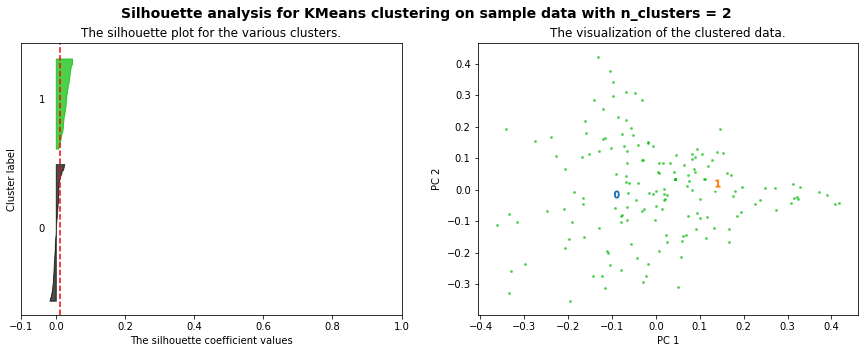

For n_clusters = 2, The average silhouette_score is : 0.012


In [75]:
#with 3 clusters
X = pdgTFVects.toarray()
plotSilhouette(2, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


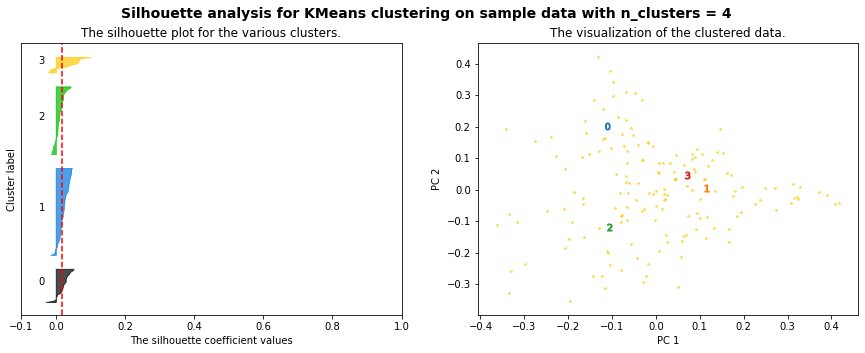

For n_clusters = 4, The average silhouette_score is : 0.018


In [76]:
#with 4 clusters
X = pdgTFVects.toarray()
plotSilhouette(4, X)

In [77]:
#I tried 2 clusters, 3 clusters and 4 clusters
#Turned out that the silhouette-score shows that 4-cluster is the best. 

In [79]:
pdgTFVects

<163x516 sparse matrix of type '<class 'numpy.float64'>'
	with 2915 stored elements in Compressed Sparse Row format>

In [80]:
pdgTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.10765161, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [81]:
pdgCoocMat = pdgTFVects * pdgTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
pdgCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [82]:
selectIndices = []
indexToCat = []
for c in set(pdgDF['source']):
    selectIndices += list(pdgDF[pdgDF['source'] == c].index)[:20]
    indexToCat += [c] * 20

In [83]:
subCoocMat = pdgCoocMat[selectIndices,:][:,selectIndices]

In [84]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[20.        , 60.        ,  0.        ,  2.        ],
       [66.        , 74.        ,  0.        ,  3.        ],
       [24.        , 75.        ,  0.30057725,  4.        ],
       [53.        , 54.        ,  0.33960466,  2.        ],
       [42.        , 45.        ,  0.36461278,  2.        ],
       [34.        , 38.        ,  0.39543994,  2.        ],
       [25.        , 76.        ,  0.40705726,  5.        ],
       [46.        , 52.        ,  0.4089243 ,  2.        ],
       [ 7.        , 59.        ,  0.41478999,  2.        ],
       [32.        , 33.        ,  0.41546595,  2.        ]])

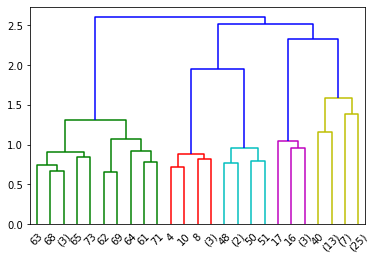

In [85]:
#By distance
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

In [86]:
#Look at the tree, I think this makes a lot of sense, sources are divided into two big clustrs 

#The first one should be all the information about pedagogy from the actual wikipedia page for 
#pedagogy, the other big cluster will be all the pedagogy information from other wikipedia pega
#related to pedagogy (or learning in general).

In [87]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
linkage_matrix_full = scipy.cluster.hierarchy.ward(pdgCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(pdgDF['source'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(pdgDF['source'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(pdgDF['source'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(pdgDF['source'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.305
Completeness: 0.296
V-measure: 0.300
Adjusted Rand Score: 0.249


In [88]:
#This is worse than k-means. 

In [131]:
#Create dic for id-mapping. 
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

pdgDF['reduced_tokens'] = pdgDF['normalized_tokens'].apply(lambda x: dropMissing(x, pdgTFVectorizer.vocabulary_.keys()))

In [132]:
dictionary = gensim.corpora.Dictionary(pdgDF['reduced_tokens'])

In [133]:
corpus = [dictionary.doc2bow(text) for text in pdgDF['reduced_tokens']]

In [135]:
gensim.corpora.MmCorpus.serialize('pdg.mm', corpus)
senmm = gensim.corpora.MmCorpus('pdg.mm')

In [136]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [143]:
sen1Bow = dictionary.doc2bow(pdgDF['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(pdgDF['paragraph-number'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 0
are: [(0, 0.09918795), (1, 0.1115817), (2, 0.08505276), (3, 0.10560063), (4, 0.09124954), (5, 0.11083845), (6, 0.1124324), (7, 0.09175797), (8, 0.094222136), (9, 0.0980765)]


In [144]:
ldaDF = pandas.DataFrame({
        'name' : pdgDF['paragraph-number'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in pdgDF['reduced_tokens']]
    })

In [145]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,1,"[(2, 0.5772633), (6, 0.40306237)]",0.0,0.000000,0.577263,0.0,0.0,0.0,0.403062,0.0,0.0,0.0
101,53,"[(1, 0.9714741)]",0.0,0.971474,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [146]:
ldaDFV = ldaDF[:5][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:5][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.099188,0.111582,0.085053,0.105601,0.091250,0.110838,0.112432,0.091758,0.094222,0.098076
1,0.000000,0.000000,0.577263,0.000000,0.000000,0.000000,0.403062,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.737595,0.000000,0.244447,0.000000,0.000000
3,0.941767,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.021482,0.024172,0.018420,0.022870,0.019762,0.807420,0.024353,0.019872,0.020406,0.021241


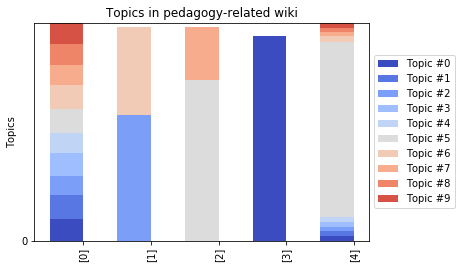

In [148]:
N = 5
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in pedagogy-related wiki')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

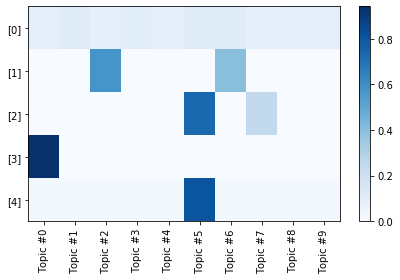

In [149]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [150]:
#top words for topic 5
senlda.show_topic(5)

#highly relevant to the idea of pedadogical learning: teacher figure is presented

[('student', 0.06610366),
 ('learn', 0.047673795),
 ('knowledge', 0.046646144),
 ('theory', 0.019651148),
 ('teacher', 0.017061494),
 ('play', 0.016858457),
 ('change', 0.014946664),
 ('behavior', 0.014878768),
 ('skill', 0.0145875),
 ('experience', 0.013616157)]

In [151]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,learn,learn,social,learn,knowledge,student,learn,student,learn,learn
1,behavior,transfer,education,stimulus,learn,learn,theory,teacher,theory,knowledge
2,student,theory,memory,information,learner,knowledge,process,learn,behavior,theory
3,memory,stimulus,pedagogy,plant,education,theory,play,pedagogue,education,structure
4,education,behavior,learn,response,people,teacher,information,active,word,plato
5,new,knowledge,student,bell,game,play,study,learner,plant,education
6,play,different,theory,example,self,change,change,education,social,people
7,pedagogy,human,academic,new,view,behavior,include,school,example,information
8,teaching,example,influence,environment,language,skill,learner,knowledge,child,question
9,knowledge,animal,people,animal,transfer,experience,example,child,teacher,problem


In [14]:
import gensim#For word2vec, etc
import requests 
import lucem_illud_2020

import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [15]:
pdgDF['tokenized_tokens'] = pdgDF['paragraph-text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
pdgDF['normalized_tokens'] = pdgDF['tokenized_tokens'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])

In [16]:
#W2V
pdgW2V = gensim.models.word2vec.Word2Vec(pdgDF['normalized_tokens'].sum())

In [17]:
#Full
pdgW2V.wv.syn0

array([[ 0.00305747,  0.00101382,  0.00693948, ...,  0.00826023,
         0.00881084,  0.00270257],
       [ 0.0010325 ,  0.00475829,  0.00048765, ...,  0.0016693 ,
         0.00397928,  0.00025032],
       [-0.00262077,  0.00305233,  0.00140678, ...,  0.00693613,
         0.00557541, -0.00386807],
       ...,
       [ 0.00027899,  0.00527856,  0.00121105, ...,  0.00023326,
         0.00223574, -0.00273316],
       [-0.00373658,  0.00040865,  0.00310256, ..., -0.00343284,
        -0.00169113, -0.00318872],
       [ 0.00489496,  0.00477295,  0.00233804, ...,  0.00093268,
         0.00098159,  0.00451787]], dtype=float32)

In [18]:
#Access back to words
pdgW2V.wv.index2word[15]

'stimulus'

In [19]:
#Words that are close to vectorized pedagogy: ability, knowlegde, evidence, learning and activities are the top 5
pdgW2V.most_similar('pedagogy')

[('information', 0.5391942262649536),
 ('behavior', 0.5350674390792847),
 ('learn', 0.5225048065185547),
 ('learning', 0.509398877620697),
 ('skills', 0.5021072030067444),
 ('evidence', 0.4984389841556549),
 ('problems', 0.48531436920166016),
 ('dewey', 0.46933358907699585),
 ('knowledge', 0.4627516269683838),
 ('skill', 0.46271711587905884)]

In [20]:
pdgW2V.save("pdgWORD2Vec")

wordsSubMatrix = []
for word in pdgW2V.wv.index2word[:50]:
    wordsSubMatrix.append(pdgW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

#PCA of the top 50 words
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

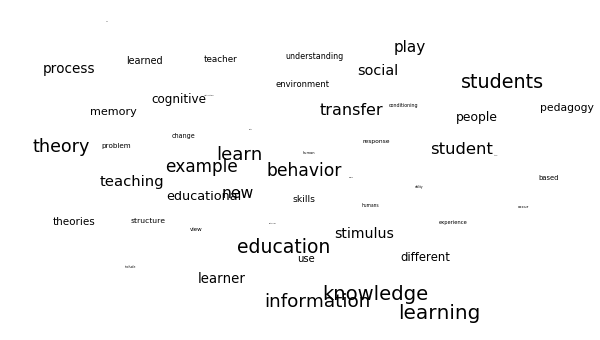

In [97]:
#Plot the graph
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(pdgW2V.wv.index2word[:50]):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (50 - i) / 50)
plt.xticks(())
plt.yticks(())
plt.show()

In [7]:
pdgDF['tokenized_words'] = pdgDF['paragraph-text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
pdgDF['normalized_words'] = pdgDF['tokenized_words'].apply(lambda x: lucem_illud_2020.normalizeTokens(x, lemma=False))

In [41]:
keywords = ['pedagogy','learn','student','teacher']

taggedDocs = []
for index, row in pdgDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['source'])
    docKeywords.append(row['paragraph-number']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
pdgDF['TaggedAbstracts'] = taggedDocs

In [42]:
pdgD2V = gensim.models.doc2vec.Doc2Vec(pdgDF['TaggedAbstracts'], size = 100) 

/opt/anaconda3/lib/python3.7/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [43]:
#Compare between texts
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = pdgD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, pdgD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

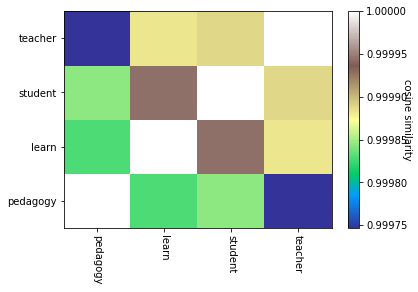

In [44]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

#students and learn are closely related to each other (implication of student being the main 
#actor of learning) This is true for pedagogical learning/teaching
#It is unexpected that pedagogy and teacher don't share very strong similarity (even though 
#pedagogical actually emphasizes the important of teacher figure in children's learing)

In [52]:
targetDocs = pdgDF['source'][110:120]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = pdgD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, pdgD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

In [53]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = pdgD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, pdgD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

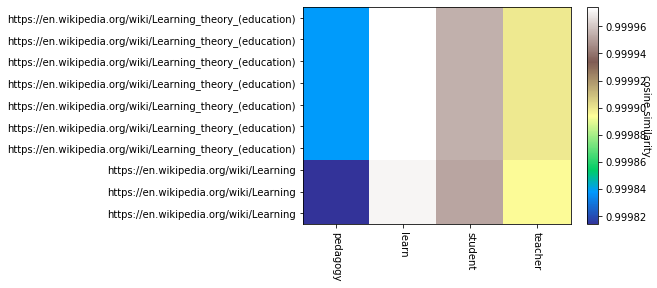

In [54]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)
#Texts related to pedagogy from the last two sources: learning (education) and learning are not 
#closely connected to the term pedagogy. 
#They are both highly representative of the term "learning" which mekes sense.

In [25]:
#words to create dimensions
tnytTargetWords = ["student","teacher","children","learning","teaching"]
#words we will be mapping
tnytTargetWords += ["pedagogy","instruction","information","example","stimulus","play","structure","new","behavior","transfer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(pdgW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [26]:
pcaWordspdg = sklearn.decomposition.PCA(n_components = 14).fit(wordsSubMatrix)
reducedPCA_datapdg = pcaWordspdg.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordspdg = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_datapdg)

In [27]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [28]:
Role = dimension(pdgW2V, ['student','children'], ['teacher','instruction'])
#pedagogy vs. discovery
PvD = dimension(pdgW2V, ['structure','instruction','pedagogy'], ['play','new','learning','stimulus'])

In [29]:
learning = ["learn","teaching","play","example","structure","stimulus"]

In [30]:
def makeDF(model, word_list):
    r = []
    p = []
    for word in word_list:
        r.append(sklearn.metrics.pairwise.cosine_similarity(pdgW2V[word].reshape(1,-1), Role.reshape(1,-1))[0][0])
        p.append(sklearn.metrics.pairwise.cosine_similarity(pdgW2V[word].reshape(1,-1), PvD.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'role': r, 'PvD': p}, index = word_list)
    return df

In [31]:
LNGdf = makeDF(pdgW2V, learning) 

In [32]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

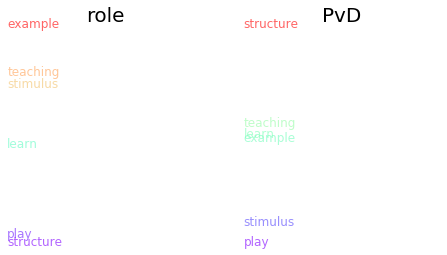

In [33]:
#plot learning in each of the dimension
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, LNGdf, 'role')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, LNGdf, 'PvD')
plt.show()

In [59]:
import networkx as nx

import sklearn #For generating some matrices
import pandas #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

In [55]:
pdgDF = pandas.read_csv('../data/pedagogy.csv', index_col = 0)
pdgDF[:5]

,text,category,url
score,,,
1,Critical pedagogy is a philosophy of education...,pedagogy,https://en.wikipedia.org/wiki/Critical_pedagogy
2,Dialogic learning is learning that takes place...,pedagogy,https://en.wikipedia.org/wiki/Dialogic_learning
3,"Student-centered learning, also known as learn...",pedagogy,https://en.wikipedia.org/wiki/Student-centred_...
4,A hidden curriculum is a side effect of school...,pedagogy,https://en.wikipedia.org/wiki/Hidden_curriculum
5,"Pedagogy (/ˈpɛdəɡɒdʒi, -ɡoʊdʒi, -ɡɒɡi/), most ...",pedagogy,https://en.wikipedia.org/wiki/Pedagogy


In [56]:
pdgDF['tokenized_sents'] = pdgDF['text'].apply(lambda x: [lucem_illud_2020.word_tokenize(s) for s in lucem_illud_2020.sent_tokenize(x)])
pdgDF['normalized_sents'] = pdgDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s) for s in x])

In [57]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [60]:
g = wordCooccurrence(pdgDF['normalized_sents'][:25].sum())

In [61]:
len(g.nodes)

854

In [62]:
len(g.edges)

12420

In [63]:
nx.to_numpy_matrix(g)[:10, :10]

matrix([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  0., 44.,  5.,  1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [64]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = lucem_illud_2020.normalizeTokens(tokenlist)
    return normalized

In [65]:
import sklearn.feature_extraction
pdgVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
pdgVects_incidence = pdgVectorizer.fit_transform(pdgDF['text'][:15])
pdgVects_incidence.shape

(15, 661)

In [66]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((pdgVectorizer.get_feature_names()[i] for i in range(pdgVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(pdgVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, pdgVectorizer.get_feature_names()[w], {'weight' : pdgVects_incidence[d, w]}) for d, w in zip(*pdgVects_incidence.nonzero())))

In [67]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 676
Number of edges: 1040
Average degree:   3.0769


/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


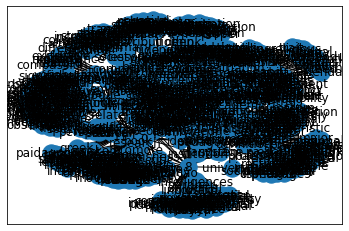

In [68]:
nx.draw_networkx(g_2mode)

In [69]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [70]:
gDoc = contractNetwork(g_2mode, 'doc')

In [71]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 15
Number of edges: 104
Average degree:  13.8667


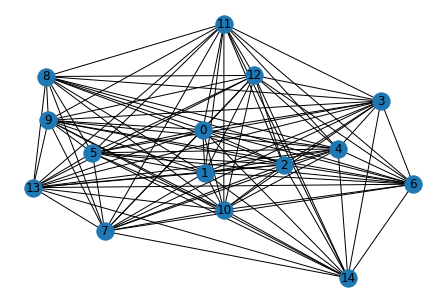

In [72]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 10)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) 

In [73]:
gWord = contractNetwork(g_2mode, 'word')
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.0804100819691493

In [74]:
g = wordCooccurrence(pdgDF['normalized_sents'][:25].sum())

In [75]:
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 5])
g.remove_nodes_from(list(nx.isolates(g)))

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

Name: 
Type: Graph
Number of nodes: 65
Number of edges: 121
Average degree:   3.7231


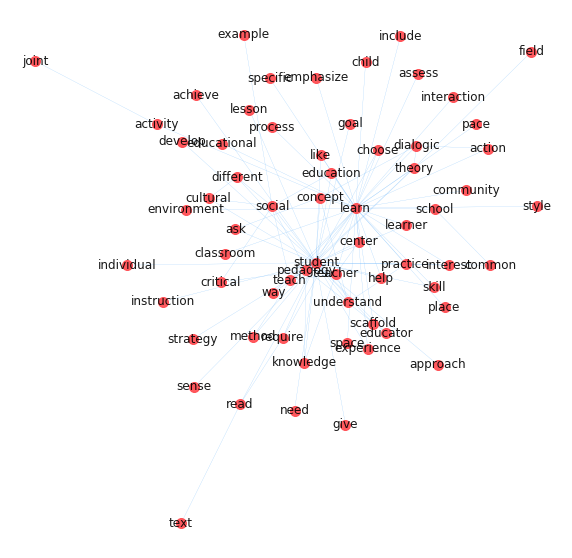

In [76]:
giant = max(connected_component_subgraphs(g), key=len) # keep just the giant connected component
print(nx.info(giant))

layout = nx.spring_layout(giant, weight='weight', iterations= 10)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue')

In [77]:
studentNeighbors = gWord.neighbors('student')
studentNeighborsPlus1 = set(studentNeighbors)
for n in studentNeighbors:
    studentNeighborsPlus1 |= set(giant.neighbors(n))

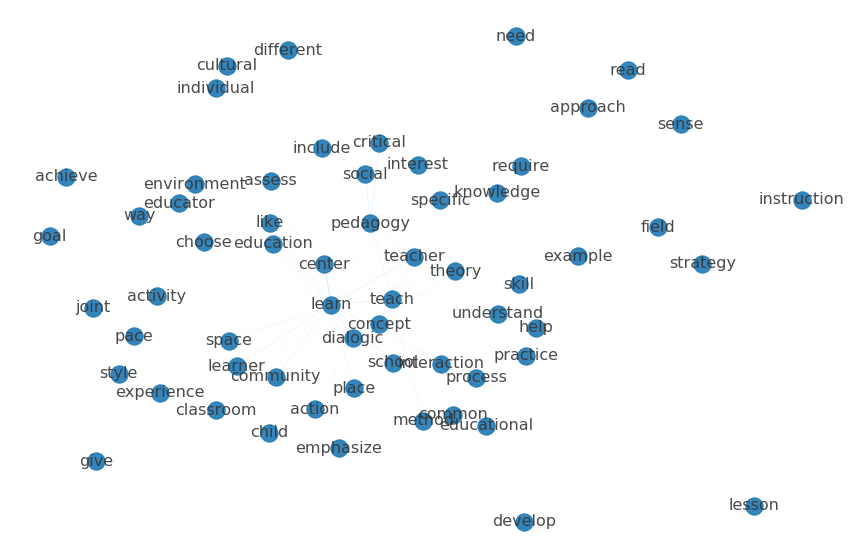

In [78]:
g_student2 = giant.subgraph(studentNeighborsPlus1)
layout_amer = nx.spring_layout(g_student2, weight='weight', iterations= 10, k = .3)
fig, ax = plt.subplots(figsize = (15,10))
centralities_amer = nx.eigenvector_centrality(g_student2)
maxC = max(centralities_amer.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in g_student2.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_student2.edges(data = True)))
nx.draw(g_student2, ax = ax, pos = layout_amer, labels = {n:n for n in g_student2.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_student2.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

In [79]:
dcentralities = nx.degree_centrality(giant)

In [80]:
dcentralities['student']

0.65625

In [81]:
max(dcentralities.items(), key = lambda x : x[1])

('student', 0.65625)

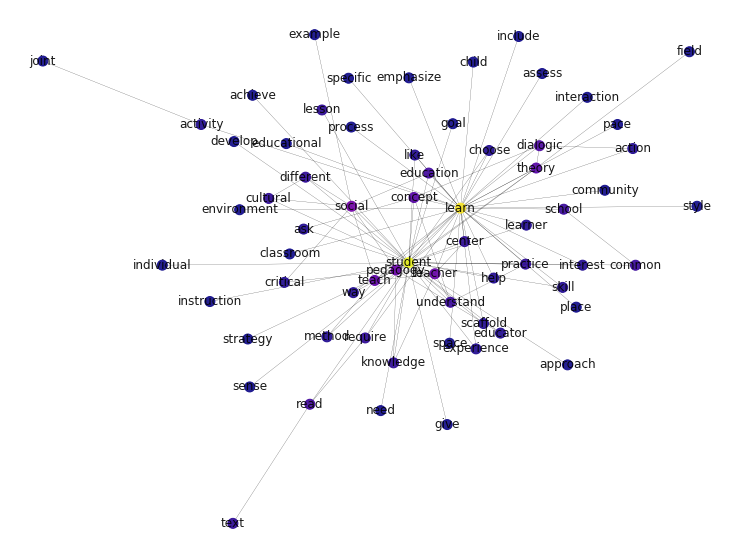

In [82]:
#Plot semantic network
fig, ax = plt.subplots(figsize = (13,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 



In [83]:
import spacy
nlp = spacy.load('en')
def posCooccurrence(normalized_sents, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in normalized_sents:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

In [84]:
gNN = posCooccurrence(pdgDF['normalized_sents'].sum(), 'NN')
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 415
Number of edges: 3043
Average degree:  14.6651


In [85]:
#treming by nodes
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 30]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 43
Number of edges: 391
Average degree:  18.1860


In [86]:
#treming by edges
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 5])
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 43
Number of edges: 198
Average degree:   9.2093


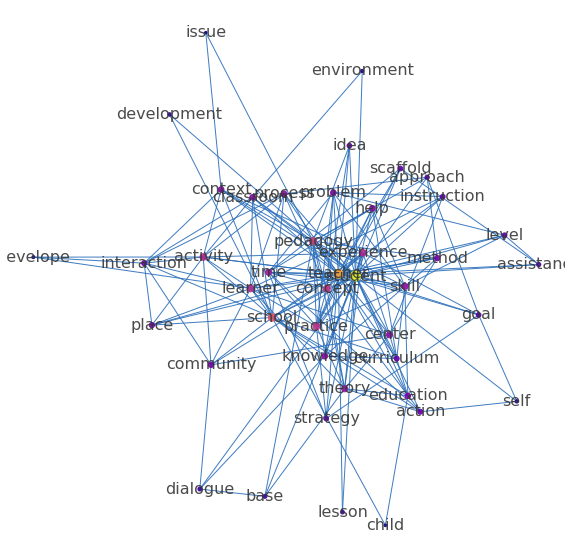

In [87]:
#Ego-network
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 10)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )